#### About

Predicts the nex open price of a stock for a given time period. Trained on multiple tickers.

##### TODO

- ~~simulate buying stocks (buy/sell decisions)~~
- ~~adjust LSTM~~
- ~~add regulation (L2 regularization/validation)~~
- ~~try: shorter LSTM sequence~~
- ~~investigate: why are all of the outputs nearly the same?~~
- ~~the plotting/prediction plots might be wrong, since the interpolation is great~~
- ~~use z-score normalization instead of min-max~~

In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
import numpy as np
import datetime, pickle
np.set_printoptions(suppress=True)

print(tf.__version__)
# This code allows for the GPU to be utilized properly.
tf.autograph.set_verbosity(0)
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

print(physical_devices)

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def sampleDataset(data, num_samples, interval_len, feature_size, offset=0):
    # creates samples of data from a dataset
    # returns the intervals, and the target price changes

    samples = np.ndarray((num_samples, interval_len, feature_size))
    target_prices = np.ndarray((num_samples, feature_size))
    for x in range(num_samples):
        start_index = round(x * (data.shape[0] - interval_len - 1 - offset) / num_samples) + offset
        # data_range = data.shape[0] - offset

        samples[x] = data[start_index:start_index + interval_len]
        target_prices[x] = data[start_index + interval_len]
    
    return samples, target_prices

def normalize_data(data, method="one"):
    if method=="one":
        maxes = np.max(data, axis=0)
        mins = np.min(data, axis=0)
        return (data - mins) / (maxes - mins)
    elif method=="zscore":
        mean = np.mean(data, axis=0)
        stdev = np.std(data, axis=0)
        return (data - mean) / stdev

In [3]:
# Calculate hourly price changes for the ticker.

df = pd.read_csv("a.csv")

# TICKER = list(df.loc[:, "Symbol"])[:100]
# TICKER = ["MSFT", "AAPL", "NVDA", "MMM", "ABBV", "ADBE", "GOOGL", "T", "CMCSA", "DIS", "EA", "FOX", "META", "NFLX", "WBD", "ABNB", "TSLA", "AMZN", "DBX"]
TICKER = ["^GSPC"]

DATASET_SIZE = 10092 # Number of samples PER TICKER
INTERVAL = 7
FEATURE_SIZE = 5 # open, high, low, close, volume
DATA_OFFSET = 14000 # offset from latest data

# fetch hists
try:
    with open("hists.dat", "rb") as f:
        hists = pickle.load(f) 
except:
    hists = []
    for x in range(len(TICKER)):
        print("LOADING TICKER " + str(x) + "/" + str(len(TICKER)), end="\r")
        hist = yf.Ticker(TICKER[x]).history(interval="1d", period="max")
        if not hist.empty and np.sum(np.isnan(hist.loc[:, "Open"].to_numpy())) == 0:
            hist.drop(columns=["Dividends", "Stock Splits"], inplace=True)
            hists.append(hist)

# Define
price_intervals = np.ndarray((len(hists), DATASET_SIZE, INTERVAL, FEATURE_SIZE))
target_prices = np.ndarray((len(hists), DATASET_SIZE, FEATURE_SIZE))
max_prices = np.ndarray((len(hists),))
min_prices = np.ndarray((len(hists),))
means = np.ndarray((len(hists),))
stdevs = np.ndarray((len(hists),))

# Process features/data
for x in range(len(hists)):

    hist = hists[x]
    display(hist)
    columns = [hist.loc[:, col].to_numpy() for col in hist.columns]

    max_prices[x] = np.max(columns[0])
    min_prices[x] = np.min(columns[0])
    means[x] = np.mean(columns[0])
    stdevs[x] = np.std(columns[0])
    data = np.stack(columns, axis=1)
    data = normalize_data(data, method="zscore")

    price_intervals[x], target_prices[x] = sampleDataset(data, DATASET_SIZE, INTERVAL, FEATURE_SIZE, offset=DATA_OFFSET)


data_split = np.copy(price_intervals)
targets_split = np.copy(target_prices)

price_intervals = price_intervals.reshape((len(hists) * DATASET_SIZE, INTERVAL, FEATURE_SIZE))
target_prices = target_prices.reshape((len(hists) * DATASET_SIZE, FEATURE_SIZE))

print(hists[0][:8])
print(price_intervals[0][:7])
print(target_prices[0][:7])

with open("hists.dat", "wb") as f:
    pickle.dump(hists, f)


,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2023-11-20 00:00:00-05:00,4511.700195,4557.109863,4510.359863,4547.379883,3644790000
2023-11-21 00:00:00-05:00,4538.770020,4542.140137,4525.509766,4538.189941,3511080000
2023-11-22 00:00:00-05:00,4553.040039,4568.430176,4545.049805,4556.620117,3042810000


                                Open       High        Low      Close  Volume
Date                                                                         
1927-12-30 00:00:00-05:00  17.660000  17.660000  17.660000  17.660000       0
1928-01-03 00:00:00-05:00  17.760000  17.760000  17.760000  17.760000       0
1928-01-04 00:00:00-05:00  17.719999  17.719999  17.719999  17.719999       0
1928-01-05 00:00:00-05:00  17.549999  17.549999  17.549999  17.549999       0
1928-01-06 00:00:00-05:00  17.660000  17.660000  17.660000  17.660000       0
1928-01-09 00:00:00-05:00  17.500000  17.500000  17.500000  17.500000       0
1928-01-10 00:00:00-05:00  17.370001  17.370001  17.370001  17.370001       0
1928-01-11 00:00:00-05:00  17.350000  17.350000  17.350000  17.350000       0
[[-0.42987943 -0.45467948 -0.45440793 -0.45361701 -0.50582021]
 [-0.42795609 -0.4533623  -0.45239826 -0.45331692 -0.49794862]
 [-0.4276594  -0.45438106 -0.45342913 -0.45457933 -0.5035917 ]
 [-0.42890753 -0.45456629 -0.45

In [4]:
# def normalize(data, maxes=1, type="zscore"):
#     if type == "one":
#         return data / maxes
#     elif type == "zscore":
#         return (data - np.mean(data)) / np.std(data)

# print(price_intervals[0])
# print(price_intervals.shape)
# print(np.max(price_intervals, axis=0)[0])
# print(max_prices[0])
# price_intervals = normalize(price_intervals, maxes=max_prices, type="one")
# print(price_intervals[0])
# target_prices = normalize(target_prices, maxes=max_prices, type="one")

In [5]:
# Create LSTM model
LEARNING_RATE = 0.001
REG_FACTOR = 0
VAL_RATIO = 0

# Define the LSTM model
model = keras.Sequential()
model.add(keras.layers.Input((INTERVAL, FEATURE_SIZE)))
model.add(keras.layers.LSTM(units=64, kernel_regularizer=keras.regularizers.l2(REG_FACTOR), return_sequences=True))
model.add(keras.layers.LSTM(units=32, kernel_regularizer=keras.regularizers.l2(REG_FACTOR)))
# model.add(keras.layers.Dense(units=64, activation="relu", kernel_regularizer=keras.regularizers.l2(REG_FACTOR)))
# model.add(keras.layers.Dense(units=EXTENSION, activation="linear", kernel_regularizer=keras.regularizers.l2(REG_FACTOR)))
# model.add(keras.layers.LSTM(units=32, input_shape=(INTERVAL, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(units=32, input_shape=(INTERVAL, 1)))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=64, activation="relu"))
# model.add(keras.layers.Dense(units=64, activation="relu"))
model.add(keras.layers.Dense(units=FEATURE_SIZE, activation="linear"))

# Compile the model
model.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model.build((None, INTERVAL, FEATURE_SIZE))
model.summary()

callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 32,773
Trainable params: 32,773
Non-trainable params: 0
_________________________________________________________________


In [6]:
num_epochs = 1000
batch_size = 256
TRADING_LENGTH = 28
SPLIT_INDEX = 1 + TRADING_LENGTH

print(price_intervals.shape)

# Train the model
train_hist = model.fit(price_intervals[:-SPLIT_INDEX], target_prices[:-SPLIT_INDEX], epochs=num_epochs, batch_size=batch_size, validation_split=VAL_RATIO, callbacks=[])

# Evaluate the model
metrics = model.evaluate(price_intervals, target_prices)

# Make predictions
N = 0
predictions = model.predict(np.expand_dims(price_intervals[N], axis=0))
print("PREDICTION: " + str(predictions[0,0]))
print("ACTUAL: " + str(target_prices[N,0]))
print("ERROR (%): " + str((predictions[0,0] - target_prices[N,0]) / target_prices[N,0] * 100))

predictions = model.predict(price_intervals[:10,])
print(predictions)

plt.plot(train_hist.history["loss"], color="blue")
plt.plot(train_hist.history["val_loss"], color="green")

(10092, 7, 5)
Epoch 1/1000


In [7]:
model.save("model-not_trained_on_recent")

INFO:tensorflow:Assets written to: model-not_trained_on_recent\assets


INFO:tensorflow:Assets written to: model-not_trained_on_recent\assets


In [ ]:
from numpy import NaN

def get_samples(hists, interval, offset=0, steps=0):
    num_hists = len(hists)
    samples = np.ndarray((num_hists, interval + steps))
    timestamps = np.ndarray((num_hists, 2), dtype="datetime64[s]")
    for x in range(num_hists):
        hist = hists[x]

        hist_times = np.asarray(hist.index.astype(np.int64) / (10 ** 9), dtype="datetime64[s]")
        timestamps[x] = np.array((hist_times[-interval - offset], hist_times[-1 - offset + steps]))
        open_prices = hist.loc[:, "Open"].to_numpy()

        samples[x] = open_prices[-interval - offset:open_prices.shape[0] -offset + steps]

    return samples, timestamps

def get_inputs(hists, interval, feature_size, offset=0):
    num_hists = len(hists)
    inputs = np.ndarray((num_hists, interval, feature_size))
    for x in range(num_hists):
        hist = hists[x]
        
        columns = [hist.loc[:, col].to_numpy() for col in hist.columns]
        data = np.stack(columns, axis=1)
        data = normalize_data(data, method="zscore")
        # print(data)

        inputs[x] = data[-interval - offset:-offset]
    
    return inputs

def format_datetime(timestamp):
    return timestamp.astype(datetime.datetime).strftime("%m/%d/%Y, %H:%M")

def plot(ticker, sample, timestamps, predictions=np.array((NaN,)), actual=np.array((NaN,)), actual_end=None, offset=0, change_error=False):
    print("=== " + ticker + ": " + "open" + " ===")
    print("Start: " + format_datetime(timestamps[0]))
    print("  End: " + format_datetime(timestamps[1]))
    
    # print(sample.shape)
    # print(offset)
    sample = sample[offset:]
    # print(sample.shape)
    # print("===")
    actual = actual[offset:]

    fig = plt.figure(figsize=(12, 3))
    ax_sample = fig.add_subplot(141)
    ax_sample.plot(sample)
    ax_sample.set_title("Sample")

    if predictions[0] != NaN:
        forecast = np.concatenate((sample, predictions))
        ax_prediction = fig.add_subplot(142)
        ax_prediction.plot(forecast)
        ax_prediction.set_title("Prediction")
    else:
        print("plot(): predictions either NaN or not given")
        
    if actual[0] != NaN:
        print("Actual prices end: " + format_datetime(actual_end))
        ax_actual = fig.add_subplot(143)
        ax_actual.plot(actual)
        ax_actual.set_title("Actual")
    else:
        print("plot(): actual values either NaN or not given")

    if change_error:
        ax_error = fig.add_subplot(144)
        forecast = np.concatenate((sample, predictions))
        ax_error.plot(forecast - actual)
        ax_error.set_title("Error in prediction")

    plt.show()

def predict(model, samples, steps, max_prices, min_prices):
    '''FOR CHAINED PREDICTIONS'''
    predictions = np.ndarray((samples.shape[0], steps, samples.shape[2]))

    for x in range(steps):
        # print("==")
        # print(samples[0, x, 0])
        predictions[:, x] = model.predict(samples, verbose=0)[:]
        # print(predictions[0, x, 0])
        # predictions[:, x] = predictions[:, x] * (max_prices[x] - min_prices[x]) + min_prices[x]

        samples[:, :INTERVAL - 1] = samples[:, 1:]
        samples[:, INTERVAL - 1] = predictions[:, x]
    return predictions

In [ ]:
predictions = model.predict(price_intervals)
error = []
for N in range(len(predictions)):
    adj_pred = predictions[N] / (1 - .17)

    print("PREDICTION: " + str(predictions[N]))
    # print("ADJ PRED:   " + str(adj_pred))   
    print("ACTUAL:     " + str(target_prices[N]))
    print("ERROR IN OPEN PRICE (%): " + str((predictions[N,0] - target_prices[N,0]) / target_prices[N,0] * 100))
    error.append((predictions[N,0] - target_prices[N,0]) / target_prices[N,0] * 100)
    if error[N] > 100:
        print("HE HERE " + str(N))
    # print("ADJ ERROR IN OPEN PRICE: " + str((adj_pred[0] - target_prices[N,0]) / target_prices[N,0] * 100))
    print()

plt.plot(predictions[:, 0], color="orange")
plt.plot(target_prices[:, 0], color="blue")

# plt.plot(np.array(error).clip(-10,10), color="orange")

In [ ]:
STEPS = 1
# BACK_OFFSET = 3215
# BACK_OFFSET = np.random.randint(DATASET_SIZE)
BACK_OFFSET = SPLIT_INDEX - 3
DISPLAY_OFFSET = 7

# INTERVAL must be >= BACK_OFFSET

samples, timestamps = get_samples(hists, INTERVAL, offset=STEPS + BACK_OFFSET)

input_samples = get_inputs(hists, INTERVAL, FEATURE_SIZE, offset=STEPS + BACK_OFFSET)

actuals, actuals_end = get_samples(hists, INTERVAL, offset=STEPS + BACK_OFFSET, steps=STEPS)
# print(input_samples.shape)
# print(np.expand_dims(input_samples, axis=1).shape)
predictions = predict(model, input_samples, STEPS, max_prices, min_prices)
print(samples.shape)
print(predictions[:, :, 0].shape)
print(actuals.shape)
# print(predictions.shape)


for x in range(len(hists)):
    pred_prices = predictions[x, :, 0]
    # print(pred_prices)
    # print(max_prices[x])
    # print(min_prices[x])
    # print(pred_prices * (max_prices[x] - min_prices[x]) + min_prices[x])
    # adj_prices = pred_prices * (max_prices[x] - min_prices[x]) + min_prices[x]
    print(pred_prices[0])
    print(stdevs[x])
    print(means[x])
    adj_prices = pred_prices * stdevs[x] + means[x]
    # adj_prices = pred_prices
    # print(x)
    plot(TICKER[x], samples[x], timestamps[x], predictions=adj_prices, actual=actuals[x], actual_end=actuals_end[x][1], offset=INTERVAL - DISPLAY_OFFSET, change_error=True)
    # pred = predictions[x, :5]
    # acts = actuals[x, -STEPS:-STEPS + 5]
    # act_change = act_change[x, -STEPS:-STEPS + 5]

    


In [ ]:
''' this one is overfit, and may not work for extrapolation '''
# model = keras.models.load_model("good_model")
# model = keras.models.load_model("model")
model = keras.models.load_model("overfit_model")

In [8]:

SPLIT_INDEX = 1 + TRADING_LENGTH
hist = hists[0]
print(hist.index)
print(hist.index[:-SPLIT_INDEX])
# print(hist.index[:-SPLIT_INDEX][-1])
# print(hist.index[-SPLIT_INDEX - 1])

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-11-13 00:00:00-05:00', '2023-11-14 00:00:00-05:00',
               '2023-11-15 00:00:00-05:00', '2023-11-16 00:00:00-05:00',
               '2023-11-17 00:00:00-05:00', '2023-11-20 00:00:00-05:00',
               '2023-11-21 00:00:00-05:00', '2023-11-22 00:00:00-05:00',
               '2023-11-24 00:00:00-05:00', '2023-11-27 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24092, freq=None)
DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
          

2023-10-16 00:00:00-04:00
PLOT: Value from trading vs. value from leaving in S&P500


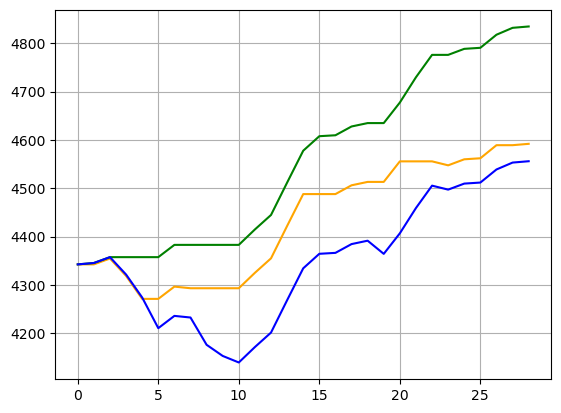

PLOT: predicted price delta vs. actaul price delta


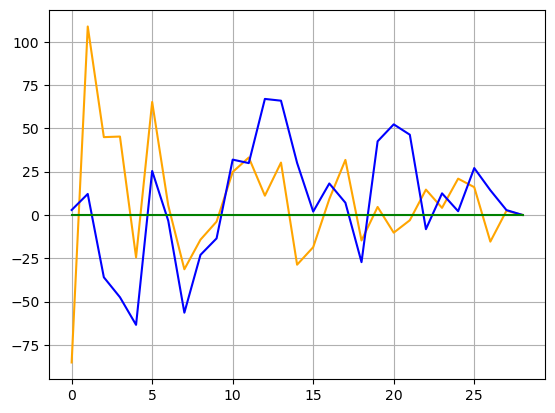

In [9]:
TESTS = 1
SHOW_PLOTS = True

hist = hists[0]
# display(hist[-OFFSET:-(OFFSET - INTERVAL)])

deltas = np.ndarray((TESTS,))
deltas_ideal = np.ndarray((TESTS,))
columns = [hist.loc[:, col].to_numpy() for col in hist.columns]

mean = np.mean(columns[0], axis=0)
stdev = np.std(columns[0], axis=0)

data_orig = np.stack(columns, axis=1)
data_orig = normalize_data(data_orig, method="zscore")


#===========================#

for i in range(TESTS):
    values = np.ndarray((TRADING_LENGTH + 1,))
    values_ideal = np.ndarray((TRADING_LENGTH + 1,))
    prices = np.ndarray((TRADING_LENGTH + 1,))

    print("TEST #" + str(i), end="\r")
    # OFFSET = np.random.randint(SPLIT_INDEX)
    # OFFSET = np.random.randint(5000)
    OFFSET = 2

    N = data_orig.shape[0] - OFFSET - TRADING_LENGTH

    prices = data_orig[N:N + TRADING_LENGTH + 1,0] * stdev + mean
    data = data_orig[N - INTERVAL + 1:N + TRADING_LENGTH + 1]
    print(hist.index[N])

    # layer data so all predictions are done at once
    data_samples = np.ndarray((TRADING_LENGTH, INTERVAL, FEATURE_SIZE))
    for x in range(TRADING_LENGTH):
        data_samples[x] = data[x:x+INTERVAL]
    predictions = model.predict(data_samples, verbose=0)[:,0] * stdev + mean

    owned = False
    money = prices[0]
    values[0] = money

    owned_ideal = False
    money_ideal = prices[0]
    values_ideal[0] = money_ideal

    ''' TRADING LOOP FOR EACH TEST '''
    for x in range(TRADING_LENGTH):
        current_value = prices[x]
        # new_value = model.predict(np.expand_dims(data[x:x + INTERVAL], axis=0), verbose=0)[0][0] * stdev + mean
        new_value = predictions[x]

        # buy
        if (new_value > current_value) and (not owned):
            owned = True
            money -= current_value
            # print(str(x) + ": " + str(new_value) + " > " + str(current_value) + ": BUY")
        # sell
        elif (new_value < current_value) and (owned):
            owned = False
            money += current_value
            # print(str(x) + ": " + str(new_value) + " < " + str(current_value) + ": SELL")

        if owned:
            values[x + 1] = prices[x + 1] + money
        else:
            values[x + 1] = money

        ''' IDEAL PERFORMANCE ''' 
        new_value = prices[x + 1]
        # buy
        if (new_value > current_value) and (not owned_ideal):
            owned_ideal = True
            money_ideal -= current_value
            # print(str(x) + ": " + str(new_value) + " > " + str(current_value) + ": BUY")
            # print(str(money_ideal))
            # print(str(current_value + money_ideal))
        # sell
        elif (new_value < current_value) and (owned_ideal):
            owned_ideal = False
            money_ideal += current_value
            # print(str(x) + ": " + str(new_value) + " < " + str(current_value) + ": SELL")

        if owned_ideal:
            values_ideal[x + 1] = prices[x + 1] + money_ideal
        else:
            values_ideal[x + 1] = money_ideal
        # print("value at step " + str(x) + ": " + str(values[x]))

    deltas[i] = values[-1] / prices[-1] - 1
    deltas_ideal[i] = values_ideal[-1] / prices[-1] - 1

    ''' DISPLAY DIAGNOSTICS '''

    if SHOW_PLOTS:
        ### VALUE OF PORTFOLIO
        print("PLOT: Value from trading vs. value from leaving in S&P500")
        plt.plot(values, color="orange")
        plt.plot(values_ideal, color="green")
        plt.plot(prices, color="blue")
        plt.grid()
        plt.show()

        # pred_shifted = np.concatenate(((predictions[0],), predictions))[:-1]
        # print(predictions)
        # print(data * stdev + mean)
        predicted_delta = predictions - prices[:-1]
        actual_delta = prices[1:] - prices[:-1]

        ### predicted price increases
        print("PLOT: predicted price delta vs. actaul price delta")
        plt.plot(np.concatenate((predicted_delta, np.array((0,)))), color="orange")
        plt.plot(np.concatenate((actual_delta, np.array((0,)))), color="blue")
        plt.plot(np.zeros((TRADING_LENGTH + 1,)), color="green")
        plt.grid()
        # plt.plot(prices, color="blue")
        plt.show()
    
    # # print("PLOT: predicted price delta")
    # # plt.plot(predicted_delta, color="orange")
    # # plt.plot(np.zeros((28,)), color="blue")
    # # # plt.plot(prices, color="blue")
    # # plt.show()
    
    # # print(predictions)
    # # print(pred_shifted)
    # # plt.plot(pred_shifted[:-1], color="orange")
    # # plt.plot(prices[:-1], color="blue")
    # # plt.show()
    # print("DELTA FROM NO TRADING: " + str(deltas[i] * 100))
    # # print("DELTA FROM NO TRADING: " + str(values[-1] - prices[-1]))


In [ ]:
# plot histogram and expected value

# a = np.clip(deltas, -0, 0)
a = deltas * 100
b = deltas_ideal * 100

hgram = np.histogram(a, bins=100, density=False)
frequencies = hgram[0]
probabilities = hgram[0] / TESTS
expected = np.sum(hgram[1][:-1] * probabilities)

hgram_ideal = np.histogram(b, bins=100, density=False)
frequencies_ideal = hgram_ideal[0]
probabilities_ideal = hgram_ideal[0] / TESTS
expected_ideal = np.sum(hgram_ideal[1][:-1] * probabilities_ideal)
# print(hgram)
# print(probabilities)
print("Mean: " + str(np.mean(a)))
print("Ideal mean: " + str(np.mean(b)))
print()
print("E[x]: " + str(expected))
print("Ideal E[x]: " + str(expected_ideal))

plt.stairs(hgram[0], hgram[1])
plt.show()